In [1]:
install.packages('fastDummies')
install.packages("DiagrammeR")


  There is a binary version available but the source version is later:
            binary source needs_compilation
fastDummies  1.7.3  1.7.4             FALSE



installing the source package 'fastDummies'


also installing the dependency 'visNetwork'





  There is a binary version available but the source version is later:
           binary source needs_compilation
DiagrammeR 1.0.10 1.0.11             FALSE


The downloaded binary packages are in
	/var/folders/k0/5jhn7d7s1l75cf1srqv1wy980000gn/T//Rtmpj01ZOf/downloaded_packages


installing the source package 'DiagrammeR'




In [2]:
setwd("/Users/gabriel/Documents/GitHub/CausalAI-Course/Labs/PD/PD10")

# Heterogenous treatment effects

### We will continue with the online discount example by Matteo Courthoud. That is, let's suppose we work in the analytics department of an online shop interested in understanding wether offering discounts to new customers increases their expenditure. In particular, we would like to know if offering discounts is more effective for some customers with respect to others, since we would prefer not to give discounts to customers that would spend anyways. Moreover, it could also be that spamming customers with pop-ups could deter them from buying, having the opposite effect.

### To understand whether and how much the discounts are effective we run an A/B test: whenever a new user visits our online shop, we randomly decide whether to offer them the discount or not. After 100 000 visits, we have collected the following dataset with relevant information beside the discount status (our treatment).

In [3]:
df <- read.csv("online_discounts.csv")
head(df)

,X,time,device,browser,region,discount,spend
,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>
1,0,10.7790063,mobile,edge,9,0,0.4551642
2,1,0.5689725,desktop,firefox,9,0,11.0368706
3,2,3.7438714,mobile,safari,7,0,1.8111930
4,3,13.3734357,desktop,other,5,0,31.9049439
5,4,0.7085752,mobile,explorer,2,1,15.4198624
6,5,10.8320878,desktop,brave,0,0,24.1239264


### Since the treatment was randomly assigned, we can use a simple difference-in-means estimator to estimate the treatment effect. We expect the treatment and control group to be similar, except for the discount, therefore we can causally attribute any difference in spend to the discount

In [4]:
model <- lm(spend ~ discount, data = df)

summary(model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),5.122072,0.04543493,112.73424,0.000000e+00
discount,1.750692,0.06421938,27.26111,4.866824e-163


### The discount seems to be effective: on average the spend in the treatment group increases by 1.75$. But are all customers equally affected? 

### To answer this question, we would like to estimate heterogeneous treatment effects, possibly at the individual level.



# Conditional Average Treatment Effects (CATE)

### There are many possible ways to estimate heterogenous treatment effects. The most common is to split the population in groups based on some observable characteristic, which in our case could be the device, the browser or the geographical region. Once you have decided which variable to split your data on, you can simply interact the treatment variable (discount) with the dimension of treatment heterogeneity. Let’s take device for example.

In [5]:
model <- lm(spend ~ discount * device, data = df)

summary(model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),5.07573921,0.06408531,79.202852,0.000000e+00
discount,1.08963150,0.09065748,12.019212,2.969281e-33
devicemobile,0.09293248,0.09076034,1.023933,3.058695e-01
discount:devicemobile,1.32109134,0.12828371,10.298200,7.387657e-25


### The interpretation of these results follows the same fashion as the previous ones: the effect of the discount on customers' spend is 1.08$, but it increases by a further 1.32$ if the customer is accessing the website from a mobile device.

### Splitting is easy for categorical variables, but for a continuous variable like time it is not intuitive where to split. Every hour? And which dimension is more informative? It would be temping to try all possible splits, but the more we split the data, the more it is likely that we find spurious results (i.e. we overfit, in machine learning lingo). It would be great if we could let the data speak and select the minimum and most informative splits.

### Moreover, the splitting problem must minimize the following objective function:

\begin{equation*}
\sum_{i}\left[\left(\tau_i-\hat{\tau} \left(X_i\right)\right)\right]
\end{equation*}


### Important issue: the objective function is unfeasible. A way out to this problem is to use Athey and Imbens (2016) outcome transformation

\begin{equation*}
Y_i^* =
\begin{cases}
 Y_i/p & W_i = 1 \\
-Y_i/(1-p) & W_i = 0
\end{cases}

\end{equation*}


### So, performing any predictive method to estimate $\hat{Y}_i^*$ will end up being the predicted CATE because 

\begin{equation*}

\mathbb{E}\left[Y_i^*|X_i=x\right] = \tau(x)

\end{equation*}

### That is, with this transformed variable we have transformed our treatment effect prediction problem to a plain outcome prediction problem. 

### A natural question arises from the definition transformed variable: what is $p$? $p$ is non other than the propensity score. That is, the probability of the individual of being treated. In an experimental study (like this one), we know this value beforehand. In observational studies, we would calculate it using a probit or logit regression. Eventhough we have programmed the discount to be given completely random (so we know $p=0.5$), it is advisable to estimate the propensity score to account for sample uncertainty.

In [6]:
# como R no lee los datos de manera correcta, y por ende, no hay variables categoricas, hay que arreglar los datos
library(dplyr)

df <- df %>%
  mutate(region = as.factor(region))

df <- df %>%
  mutate(browser = as.factor(browser))

df <- df %>%
  mutate(device = as.factor(device))




Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [ ]:
# Transformamos variables categoricas en dummies
Xi <- fastDummies::dummy_cols(df[3:5], remove_selected_columns = TRUE,
                             remove_first_dummy = TRUE)
Xi$time <- df$time

df2 <- fastDummies::dummy_cols(df, select_columns = c('region','browser','device'),
                             remove_first_dummy = TRUE)
head(df)
head(df2)
head(Xi)

# Debemos dividir de esta forma para obtener unicamente los nombres de las covariables

,X,time,device,browser,region,discount,spend
,<int>,<dbl>,<fct>,<fct>,<fct>,<int>,<dbl>
1,0,10.7790063,mobile,edge,9,0,0.4551642
2,1,0.5689725,desktop,firefox,9,0,11.0368706
3,2,3.7438714,mobile,safari,7,0,1.8111930
4,3,13.3734357,desktop,other,5,0,31.9049439
5,4,0.7085752,mobile,explorer,2,1,15.4198624
6,5,10.8320878,desktop,brave,0,0,24.1239264


,X,time,device,browser,region,discount,spend,region_1,region_2,region_3,...,region_7,region_8,region_9,browser_chrome,browser_edge,browser_explorer,browser_firefox,browser_other,browser_safari,device_mobile
,<int>,<dbl>,<fct>,<fct>,<fct>,<int>,<dbl>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,10.7790063,mobile,edge,9,0,0.4551642,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,1,0.5689725,desktop,firefox,9,0,11.0368706,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,2,3.7438714,mobile,safari,7,0,1.8111930,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,3,13.3734357,desktop,other,5,0,31.9049439,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,4,0.7085752,mobile,explorer,2,1,15.4198624,0,1,0,...,0,0,0,0,0,1,0,0,0,1
6,5,10.8320878,desktop,brave,0,0,24.1239264,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,device_mobile,browser_chrome,browser_edge,browser_explorer,browser_firefox,browser_other,browser_safari,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,time
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,10.7790063
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.5689725
3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3.7438714
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,13.3734357
5,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.7085752
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.8320878


In [10]:
X <- colnames(Xi)
X

[1] "device_mobile"    "browser_chrome"   "browser_edge"     "browser_explorer"
 [5] "browser_firefox"  "browser_other"    "browser_safari"   "region_1"        
 [9] "region_2"         "region_3"         "region_4"         "region_5"        
[13] "region_6"         "region_7"         "region_8"         "region_9"        
[17] "time"

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


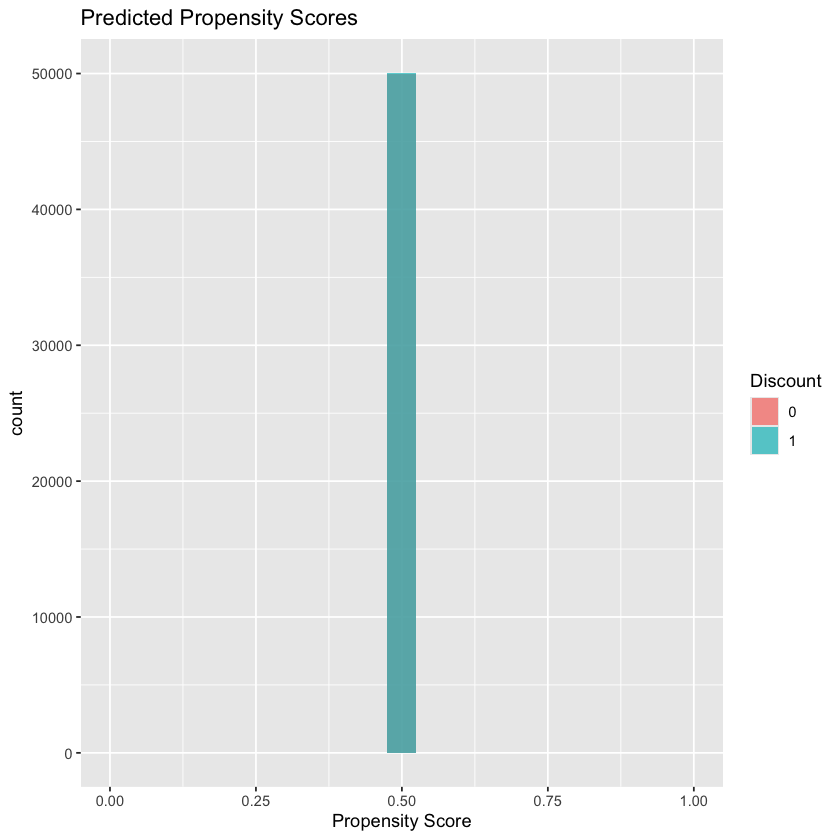

In [14]:
# Load necessary packages
# install.packages("ggplot2")
library(ggplot2)

# Fit the logistic regression model to predict propensity scores
logistic_model <- glm(discount ~ ., data = df2[,c(X,'discount')], family = binomial)
df$pscore <- predict(logistic_model, df2[X], type = "response")

# Plot the histogram with ggplot2
ggplot(df, aes(x = pscore, fill = as.factor(discount))) +
  geom_histogram(binwidth = 0.05, position = "identity", alpha = 0.7) +
  labs(
    title = "Predicted Propensity Scores",
    x = "Propensity Score",
    fill = "Discount"
  ) +
  xlim(0, 1)

### As expected, the histogram of the propensity score reveals that the treatment is completely random. Now, with the estimated propensity score of each individual we can calculate $Y_i^*$

In [15]:
df$y_star <- df$spend / (df$discount * df$pscore - (1 - df$discount) * (1 - df$pscore))

In [16]:
head(df2[X])

,device_mobile,browser_chrome,browser_edge,browser_explorer,browser_firefox,browser_other,browser_safari,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,time
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,10.7790063
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.5689725
3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3.7438714
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,13.3734357
5,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.7085752
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.8320878


### As we said before, the idea is to use $Y_i^*$ as the target of a prediction problem, since the expected value is exactly the individual treatment effect. Let’s check its average in the data.

In [17]:
mean(df$y_star, na.rm = TRUE)

[1] 1.75716

### Although $Y_i^*$ is an unbiased estimator for the individual treatment effect, it has a very high variance

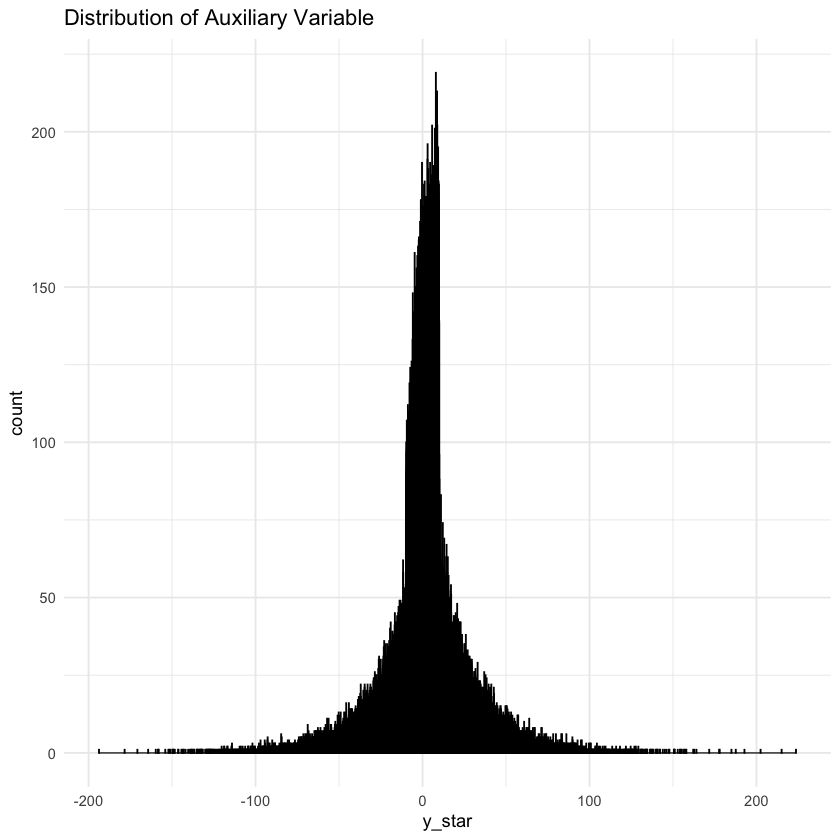

In [18]:
library(ggplot2)

ggplot(df, aes(x = y_star)) +
  geom_histogram(binwidth = 0.05, fill = "skyblue", color = "black", alpha = 0.7) +
  labs(title = "Distribution of Auxiliary Variable") +
  theme_minimal()

### Now, with all the arguments given above, we can build a regression tree with the transformed outcome to calculate the predicted CATE

In [14]:
df

X,time,device,browser,region,discount,spend,pscore,y_star
<int>,<dbl>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
0,10.7790063,mobile,edge,9,0,0.45516422,0.5141587,-0.9368578
1,0.5689725,desktop,firefox,9,0,11.03687063,0.5098886,-22.5191068
2,3.7438714,mobile,safari,7,0,1.81119304,0.4974938,-3.6043197
3,13.3734357,desktop,other,5,0,31.90494394,0.4880360,-62.3187267
4,0.7085752,mobile,explorer,2,1,15.41986237,0.5111713,30.1657412
5,10.8320878,desktop,brave,0,0,24.12392643,0.5074952,-48.9821190
6,22.0927643,desktop,safari,0,1,14.35099577,0.5005385,28.6711105
7,14.8807829,desktop,chrome,3,0,30.98908236,0.5013280,-62.1432161
8,11.1468772,desktop,safari,2,0,-0.92061600,0.4999294,1.8409721


In [19]:
vars = df[,c("time", "device", "browser", "region", "y_star")]

In [20]:
library(rpart)

tree_model <- rpart(y_star ~.,
                   data = vars[1:100,])
                

In [21]:
tree_model

n= 100 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 100 61221.290   3.711641  
   2) browser=chrome,explorer,firefox,other 51 28570.450  -3.082367  
     4) region=0,1,3,4,5,6 25 15443.290 -14.129650  
       8) device=desktop 18 11825.880 -18.356740 *
       9) device=mobile 7  2468.737  -3.260008 *
     5) region=2,7,8,9 26  7142.377   7.540024  
      10) region=7,8,9 19  3427.266   3.220422 *
      11) region=2 7  2398.322  19.264660 *
   3) browser=brave,edge,safari 49 27846.590  10.782950  
     6) region=0,2,4,5,6,7,8 36 14809.520   4.930149  
      12) browser=brave,edge 25 11669.230   1.474322  
        24) time>=9.005303 18  9466.082  -1.774799 *
        25) time< 9.005303 7  1524.500   9.829202 *
      13) browser=safari 11  2163.155  12.784300 *
     7) region=1,3,9 13  8388.881  26.990730 *

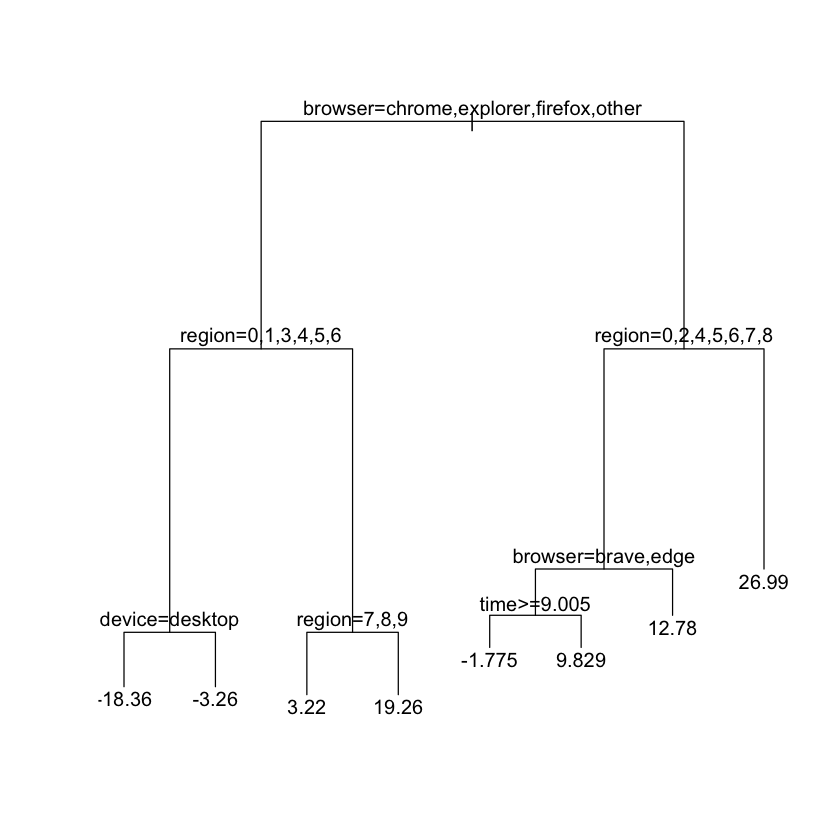

In [22]:
plot(tree_model)
text(tree_model, pretty = 0)

### Some caveats should be given about the results of this tree. First, the CATE estimates will be unbiased only if, within each leave, we have the same number of treated and control units. And second, we have used the same data to generate and evaluate the tree, which generates overfitting.

# Generating Splits

### Last but not least, how should the tree be generated? The default rule to generate splits minimizing the sum of squared errors metric, so there is no restriction on the minimum number of observations per leaf. Other commonly used rules include, mean absolute error, Gini’s impurity, and Shannon’s information. Which one performs better depends on the specific application, but the general objective is always prediction accuracy, broadly defined.

### In that regard, Athey and Imbens (2016) use a modified version of the Mean Squared Error (MSE) as splitting criterion, named the Expanded Mean Squared Error (EMSE)

\begin{equation*}

EMSE = \mathbb{E}\left[\left(Y_i-\hat{\mu}(X_i)\right)^2-Y_i^2\right]

\end{equation*}

### Luckily, there are multiple libraries where the so-called causal trees are implemented. We import CausalForestDML from Microsoft’s EconML library, one of the best libraries for causal inference

In [23]:
install.packages("grf")

also installing the dependencies 'DiceKriging', 'sandwich'





  There are binary versions available but the source versions are later:
         binary source needs_compilation
sandwich  3.1-0  3.1-1             FALSE
grf       2.3.1  2.4.0              TRUE


The downloaded binary packages are in
	/var/folders/k0/5jhn7d7s1l75cf1srqv1wy980000gn/T//Rtmpj01ZOf/downloaded_packages


installing the source packages 'sandwich', 'grf'




In [27]:
library(fastDummies)
X <- df[,c("time", "device", "browser", "region")]
X <- dummy_cols(X, remove_first_dummy = TRUE, remove_selected_columns = TRUE) # covariables
Y <- df[, "spend"] # objetivo
W <- df[, "discount"] # tratamiento
head(X)
head(Y)
head(W)

,time,device_mobile,browser_chrome,browser_edge,browser_explorer,browser_firefox,browser_other,browser_safari,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,10.7790063,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.5689725,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,3.7438714,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,13.3734357,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
5,0.7085752,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
6,10.8320878,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[1]  0.4551642 11.0368706  1.8111930 31.9049439 15.4198624 24.1239264

[1] 0 0 0 0 1 0

In [25]:
library(grf)
tree <- causal_forest(X, Y, W, num.trees = 1,
                      mtry = ncol(X), min.node.size = 1800)
# aqui se controla la profundidad del arbol de manera indirecta controlando el tamaño minimo de la muestra de los nodos en vez de controlar cuantas hojas tendra el 
# arbol como se hace en python

In [87]:
get_tree(tree, 1)

GRF tree object 
Number of training samples: 50000 
Variable splits: 
(1) split_variable: time  split_value: 12.6249 
  (2) split_variable: time  split_value: 6.85996 
    (4) * num_samples: 7219  avg_Y: 5.15 avg_W: 0.5 
    (5) * num_samples: 5917  avg_Y: 5.49 avg_W: 0.5 
  (3) split_variable: device_mobile  split_value: 0 
    (6) * num_samples: 5905  avg_Y: 6.3 avg_W: 0.5 
    (7) * num_samples: 5959  avg_Y: 7.27 avg_W: 0.5 